<a href="https://colab.research.google.com/github/reban87/Gen-AI-Basics/blob/main/RAG/rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Retrieval Augmented Generation (RAG)** is an AI framework designed to enhance the performance of large language model’s (LLM) response. It makes use of external knowledge sources to enhance these models’ generation capabilities. Let us understand the RAG Architecture with an example of learning RAG from a database of articles on RAG. The architecture is implemented using LangChain.

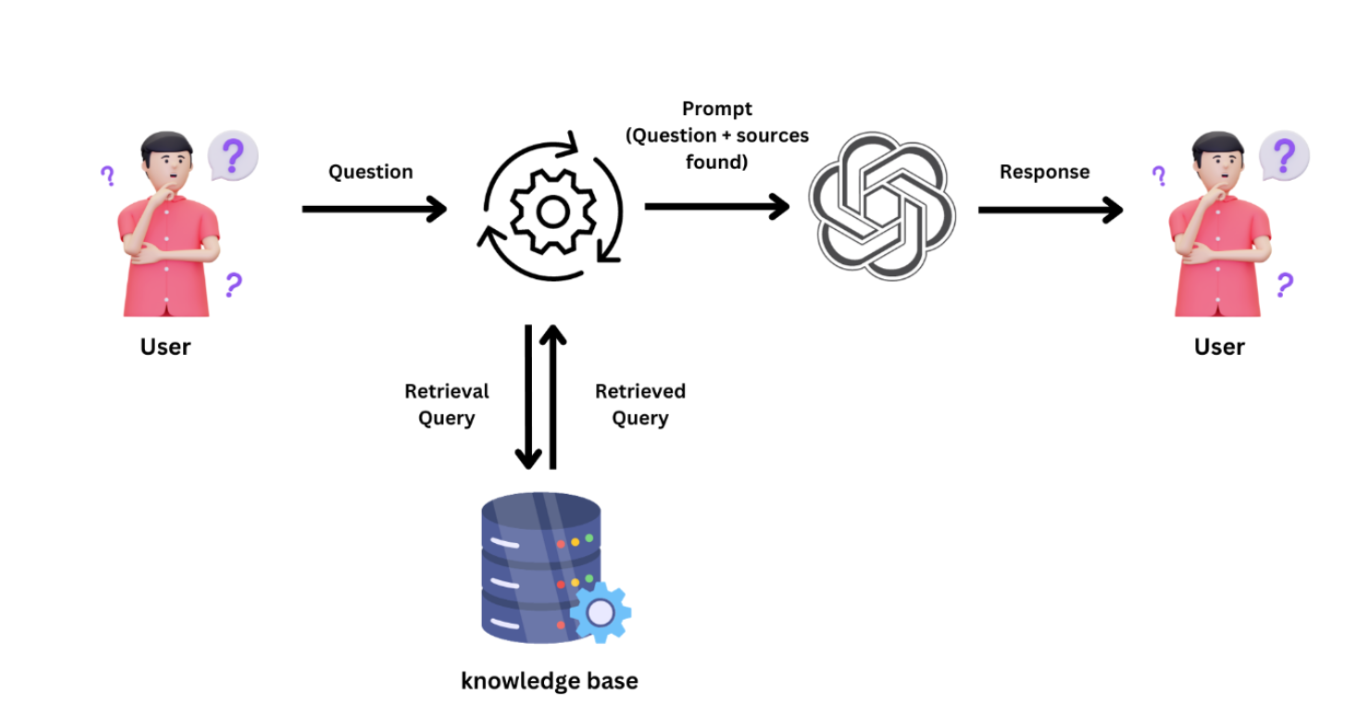

In [ ]:
from google.colab import userdata
api_key = userdata.get('gemini_api_key')

Let us check whether the api is working as expected or not

In [ ]:
import google.generativeai as genai

genai.configure(api_key=api_key)
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("what's 2+2")
print(response.text)


NameError: name 'api_key' is not defined

In [ ]:
#!pip install langchain-google-genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings


In [ ]:
model = ChatGoogleGenerativeAI(api_key=api_key, model="gemini-1.5-flash")
embeddings = GoogleGenerativeAIEmbeddings(google_api_key=api_key, model= "models/embedding-001")

In [ ]:
# Check whether the model is working properly or not
response = model.invoke(["what is 2+1"])
response

AIMessage(content='2 + 1 = 3', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e4a05661-1b70-472c-8ac2-9bcdf9f21cf3-0', usage_metadata={'input_tokens': 7, 'output_tokens': 8, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}})

In [ ]:
print(response.content)

2 + 1 = 3


In [ ]:
# Check whether the embedding works or not properly
data = embeddings.embed_query("what is 2+1")
data[:5]

[0.0192115418612957,
 -0.034294288605451584,
 -0.027753861621022224,
 -0.0017713620327413082,
 0.06048412621021271]

In [ ]:
data = embeddings.embed_documents(
    [
        "Today is Monday",
        "Today is Tuesday",
        "Today is holiday",
    ]
)
len(data), len(data[0])

(3, 768)

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    google_api_key=api_key,
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [ ]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to Nepali. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg.content

'मलाई प्रोग्रामिङ मन पर्छ। (Malai programming man parcha.)'

Chaining

We can chain our model with a prompt template like so:

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant that translates {input_language} to {output_language}.",
        ),
        ("human", "{input}"),
    ]
)

chain = prompt | llm | parser
response = chain.invoke(
    {
        "input_language": "English",
        "output_language": "Nepali",
        "input": "I love programming.",
    }
)
response

'मलाई प्रोग्रामिङ मन पर्छ। (Malai programming man parcha.)'

In [ ]:
response.content

'मलाई प्रोग्रामिङ मन पर्छ। (Malai programming man parcha.)'

**Step1**: Document Loader Load all the documents from a directory so they can be queried in your system. Depending on the type of files you have (e.g., text files, PDFs, etc.), LangChain offers different document loaders to handle various formats. In this example, we will focus on loading .txt files from a specified directory using the DirectoryLoader class.

In [ ]:
# !pip install langchain-community
# !pip install pypdf
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("demo.pdf")
docs = loader.load()
docs


In [ ]:
from langchain.prompts import PromptTemplate

In [ ]:
template = """
Answer the question based on the context below. If the context is not relevant, just reply "I don't know"

Context: {context}

Question: {question}
"""

prompt = PromptTemplate(template=template)
print(prompt.format(context = "Here is some context", question = "Here is a question"))

 
Answer the question based on the context below. If the context is not relevant, just reply "I don't know"

Context: Here is some context

Question: Here is a question



In [ ]:
llm_chain = prompt | model
response = llm_chain.invoke({"context": "The name of the company is Softwarica", "question": "what is the name of the company?"})
response.content

'Softwarica'

**Step2**: Load the documents, split it and store in the Chroma

In [ ]:
# !pip install langchain langchain_community langchain_chroma
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
splits = text_splitter.split_documents(docs)
# print(splits)
vector_store = Chroma.from_documents(splits, embedding=embeddings)

**STEP 3**: Retrieve and generate the relevant snippets from the document

In [ ]:
#@ STEP 3: Retrieve and generate using the relevant snippents from the pdf.

#@ Lets create a prompt for the model
from multiprocessing import context
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

template = """
Answer the question based on the context below. If the context is not relevant, just reply "Hmmm! I don't know"

context: {context}

question: {question}
"""

prompt = PromptTemplate(template=template)
# print(prompt.format(context="Here is the context", question="Here is the question"))

retriever = vector_store.as_retriever()

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {
        "context": retriever | format_docs, "question": RunnablePassthrough()}

    | prompt | model | parser

)

In [ ]:
rag_chain.invoke("What are the challenges of NLP Models?")

'NLP models face challenges due to the complexity and diversity of natural language.  These include ambiguity, variability, context-dependence, figurative language, domain-specificity, noise, and a lack of labeled data.'